In [2]:
# tf2 environment
import os
import glob
import zipfile
import numpy as np

import matplotlib.pyplot as plt


In [44]:
def read_tsv_and_create_dict(file_path):
    participant_mapping = {}
    
    with open(file_path, 'r') as file:
        header = file.readline()  # Skip the header line
        for line in file:
            participant_id, sub_id_bids, scan_id, session, age, sex, group = line.strip().split('\t')
            
            # Convert age to float
            age = float(age)
            
            # Check if the participant_id is already in the mapping, if not, assign it a unique identifier
            if participant_id not in participant_mapping:
                unique_id = len(participant_mapping)
                participant_mapping[participant_id] = {'id': unique_id, 'scan_ids': {}, 'age': {}}  # Initialize nested dictionaries
            
            # Append the scan_id and age to the participant's dictionary
            participant_mapping[participant_id]['scan_ids'][scan_id] = age
            participant_mapping[participant_id]['age'][scan_id] = age
    
    return participant_mapping

In [52]:
import pandas as pd
def read_tsv_and_create_dataframe(file_path):
    participant_data = []
    
    with open(file_path, 'r') as file:
        header = file.readline()  # Skip the header line
        for line in file:
            participant_id, sub_id_bids, scan_id, session, age, sex, group = line.strip().split('\t')
            
            # Convert age to float
            age = float(age)
            
            # Append data to participant_data list
            participant_data.append([participant_id, scan_id, age, sex])
            
    # Create a DataFrame with the participant data
    columns = ['participant_id', 'scan_id', 'age', 'sex']
    df = pd.DataFrame(participant_data, columns=columns)
    
    return df

In [53]:
# Specify the path to your TSV file
file_path = '/home/andjela/Documents/intra-inter-ddfs/src/participants.tsv'

# Call the function to create the dictionary for all 64 patients
participant_mapping = read_tsv_and_create_dict(file_path)

# Obtain dictionnary with subject, scan_id, age and sex
full_df = read_tsv_and_create_dataframe(file_path)


In [3]:
def find_scan_ids(name):
    #Outputs patient number, moving and fixed image scanID as strings for further analysis
    #Possible folder name pairs are below with each string differing in length
    # name = 'CL_Dev_004_CL_Dev_008'
    # name1 = 'CL_Dev_004_PS15_048'
    # name2 = 'PS15_048_CL_Dev_004'
    # name3 = 'PS15_048_PS17_017'
    # name4 = 'PS16_058_PS1183-10-1'

    #idx contains a list of strings of a given name
    idx = [s for s in name.split("_")]
    

    if len(idx) == 6:
        
        mov = f'{idx[0]}_{idx[1]}_{idx[2]}'
        fix = f'{idx[3]}_{idx[4]}_{idx[5]}'
        return(mov, fix)

    elif len(idx) == 5:
        if 'CL' in idx[0]:
            mov = f'{idx[0]}_{idx[1]}_{idx[2]}'
            fix = f'{idx[3]}_{idx[4]}'
            
            return(mov, fix)
        elif 'PS' in idx[0]:
            mov = f'{idx[0]}_{idx[1]}'
            fix = f'{idx[2]}_{idx[3]}_{idx[4]}'
            
            return(mov, fix)

    elif len(idx) == 4:
        mov = f'{idx[0]}_{idx[1]}'
        fix = f'{idx[2]}_{idx[3]}'
        return(mov, fix)

    elif len(idx) == 3 and '-' not in idx[2]:
        mov = f'{idx[0]}'
        fix = f'{idx[1]}_{idx[2]}'
        return(mov, fix)

    elif len(idx) == 3 and '-' in idx[2]:
        mov = f'{idx[0]}_{idx[1]}'
        fix = f'{idx[2]}'
        return(mov, fix)

    else:
        print('Not a corresponding folder name', name)

## Dataframes for both training schemes

In [76]:
def calculate_average_abs_log_jacobian(volume):
    # Iterate through the image_3d and store the absolute values of all elements in abs_values
    abs_values = np.abs(volume)

    # Calculate the average of the absolute values
    average_absolute = np.mean(abs_values)

    return average_absolute

In [77]:
def calculate_average_log_jacobian(volume):
    # Iterate through the image_3d and store the absolute values of all elements in abs_values

    # Calculate the average of the absolute values
    average_absolute = np.mean(volume)

    return average_absolute

# PLOTS

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

In [5]:
file_path = 'C:\\Users\\andje\\Downloads\\pairs_ias_r.csv'
pairs_ias_r = pd.read_csv(file_path)

file_path = 'C:\\Users\\andje\\Downloads\\pairs_ia_r.csv'
pairs_ia_r = pd.read_csv(file_path)

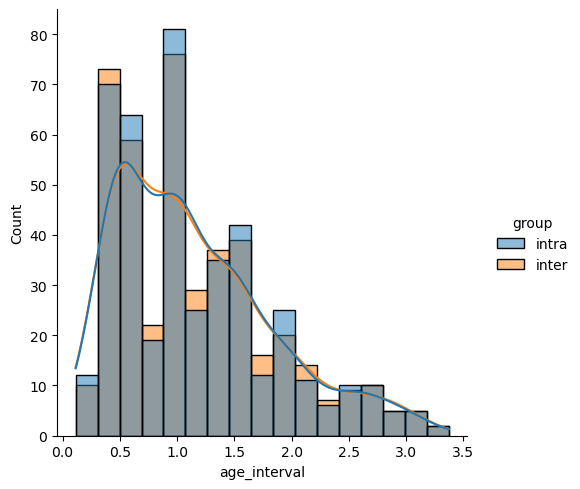

In [13]:
sns.displot(pairs_ia_r, x="age_interval", hue="group", kde=True)

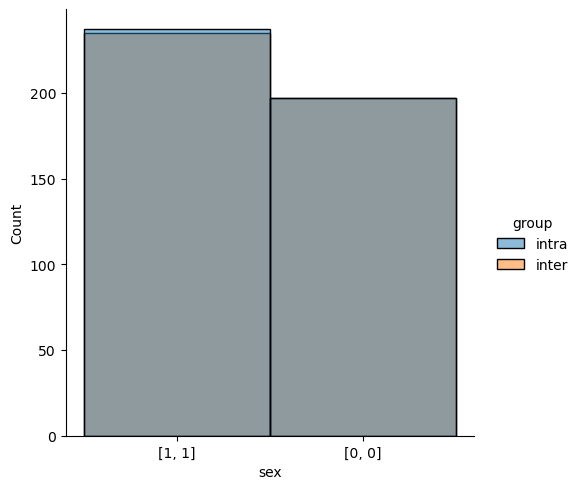

In [40]:
# sns.displot(pairs_ias_r, x="init_age", hue="group", kind="kde", fill=True)
sns.displot(pairs_ias_r, x="sex", hue="group", bins=25)

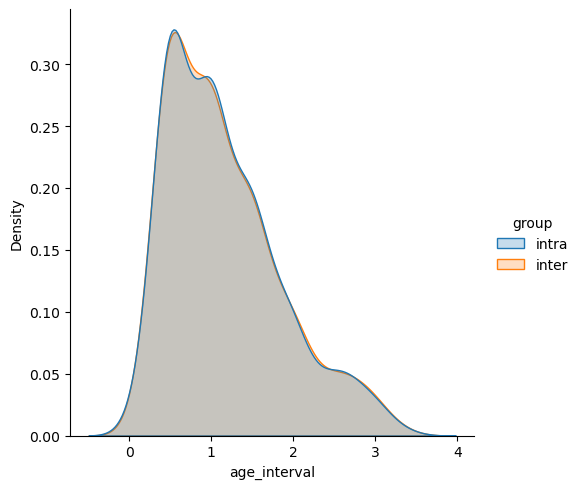

In [54]:
sns.displot(pairs_ia_r, x="age_interval", hue="group", kind="kde", fill=True)

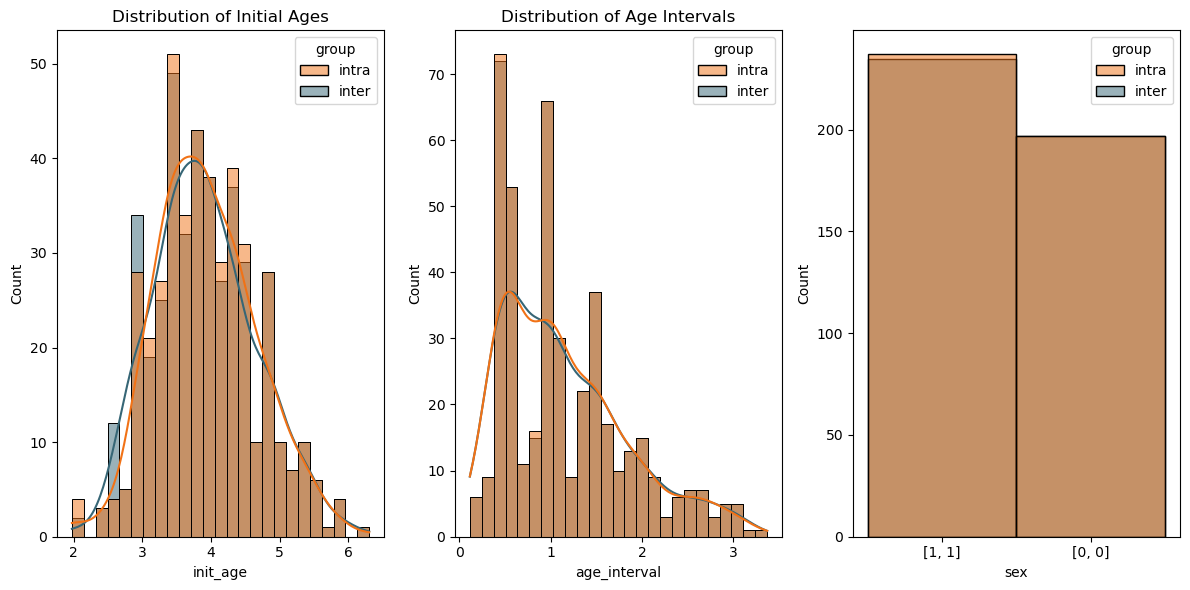

In [46]:
# Define the color palette for groups
# palette = {"intra": (1.0, 0.4980392156862745, 0.054901960784313725), "inter": (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)}
palette = {"intra": (0.944, 0.448, 0.088), "inter": (0.212, 0.4, 0.464)}

# Create a matplotlib figure and axes for subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Plot the first displot on the first subplot
sns.histplot(data=pairs_ias_r, x="init_age", hue="group", kde=True, bins=25, palette=palette, ax=axes[0])

# Set title for the first subplot
axes[0].set_title('Distribution of Initial Ages')

# Plot the second displot on the second subplot
sns.histplot(data=pairs_ias_r, x="age_interval", hue="group", kde=True, bins=25, palette=palette, ax=axes[1])

sns.histplot(data=pairs_ias_r, x="sex", hue="group", bins=25, palette=palette, ax=axes[2])
# Set title for the second subplot
axes[1].set_title('Distribution of Age Intervals')
# Get the default Seaborn color palette
default_palette = sns.color_palette()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\andje\AppData\Local\Temp\ipykernel_147344\3327318102.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(['Male', 'Female'])


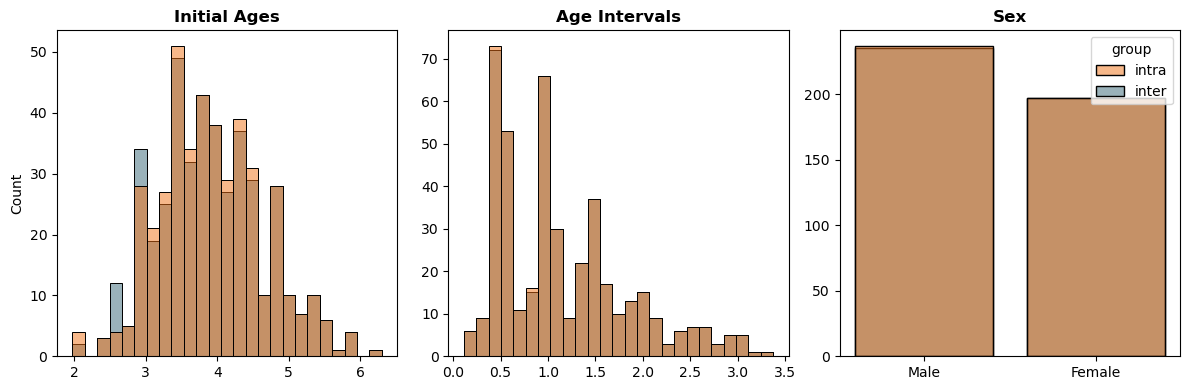

In [87]:
# Define the color palette for groups
# palette = {"intra": (1.0, 0.4980392156862745, 0.054901960784313725), "inter": (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)}
palette = {"intra": (0.944, 0.448, 0.088), "inter": (0.212, 0.4, 0.464)}

# Create a matplotlib figure and axes for subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot the first displot on the first subplot

sns.histplot(data=pairs_ias_r, x="init_age", hue="group", bins=25,fill=True, palette=palette, ax=axes[0])
# sns.kdeplot(pairs_ias_r, x="init_age", hue="group", fill=True, palette=palette, ax=axes[0])

# Set title for the first subplot
axes[0].set_xlabel('')
axes[0].set_title('Initial Ages', fontweight='bold')
axes[0].get_legend().remove()

# Plot the second displot on the second subplot
sns.histplot(data=pairs_ias_r, x="age_interval", hue="group", bins=25,fill=True, palette=palette, ax=axes[1])
# sns.kdeplot(pairs_ias_r, x="age_interval", hue="group", fill=True, palette=palette, ax=axes[1])

sns.histplot(pairs_ias_r, x="sex", hue="group", fill=True, palette=palette, shrink=.8, ax=axes[2])
# Set title for the second subplot
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].get_legend().remove()
axes[1].set_title('Age Intervals', fontweight='bold')
axes[2].set_ylabel('')
axes[2].set_xlabel('')
axes[2].set_title('Sex', fontweight='bold')
axes[2].set_xticklabels(['Male', 'Female'])
# Get the default Seaborn color palette
default_palette = sns.color_palette()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

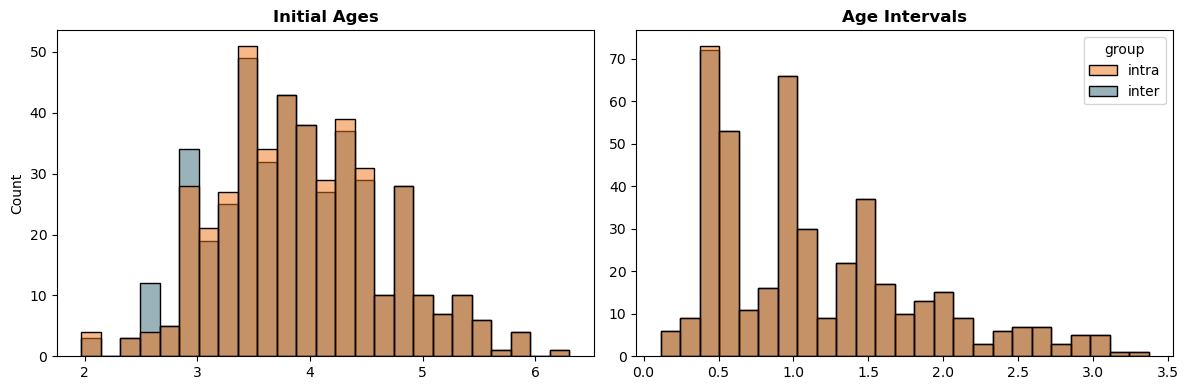

In [90]:
# Define the color palette for groups
# palette = {"intra": (1.0, 0.4980392156862745, 0.054901960784313725), "inter": (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)}
palette = {"intra": (0.944, 0.448, 0.088), "inter": (0.212, 0.4, 0.464)}

# Create a matplotlib figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first displot on the first subplot

sns.histplot(data=pairs_ia_r, x="init_age", hue="group", bins=25,fill=True, palette=palette, ax=axes[0])
# sns.kdeplot(pairs_ias_r, x="init_age", hue="group", fill=True, palette=palette, ax=axes[0])

# Set title for the first subplot
axes[0].set_xlabel('')
axes[0].set_title('Initial Ages', fontweight='bold')
axes[0].get_legend().remove()

# Plot the second displot on the second subplot
sns.histplot(data=pairs_ia_r, x="age_interval", hue="group", bins=25,fill=True, palette=palette, ax=axes[1])
# sns.kdeplot(pairs_ias_r, x="age_interval", hue="group", fill=True, palette=palette, ax=axes[1])

# Set title for the second subplot
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_title('Age Intervals', fontweight='bold')

# Get the default Seaborn color palette
default_palette = sns.color_palette()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
file_path = 'C:\\Users\\andje\\Downloads\\logJac_ia_r_NO.csv'
logJac_ia_r_NO = pd.read_csv(file_path)

file_path = 'C:\\Users\\andje\\Downloads\\logJac_ia_r_O.csv'
logJac_ia_r_O = pd.read_csv(file_path)

In [45]:
file_path = 'C:\\Users\\andje\\Documents\\Biomed\\Doctorat\\Projets\\intra-inter-classification\\src\\all-participants.tsv'

# Call the function to create the dictionary for all 96 patients
participant_mapping = read_tsv_and_create_dict(file_path)

In [46]:
participant_mapping

{'10006': {'id': 0,
  'scan_ids': {'PS14_001': 4.1389,
   'PS14_053': 4.6639,
   'PS14_120': 5.1389,
   'PS15_061': 5.5556,
   'PS15_138': 6.0167},
  'age': {'PS14_001': 4.1389,
   'PS14_053': 4.6639,
   'PS14_120': 5.1389,
   'PS15_061': 5.5556,
   'PS15_138': 6.0167}},
 '10007': {'id': 1,
  'scan_ids': {'PS14_121': 3.4722, 'PS15_062': 3.8889, 'PS15_139': 4.35},
  'age': {'PS14_121': 3.4722, 'PS15_062': 3.8889, 'PS15_139': 4.35}},
 '10008': {'id': 2,
  'scan_ids': {'PS14_046': 3.7306,
   'PS14_079': 4.2028,
   'PS16_001': 5.2944,
   'PS16_045': 5.8139,
   'PS17_018': 6.8111},
  'age': {'PS14_046': 3.7306,
   'PS14_079': 4.2028,
   'PS16_001': 5.2944,
   'PS16_045': 5.8139,
   'PS17_018': 6.8111}},
 '10009': {'id': 3,
  'scan_ids': {'PS14_070': 3.4333,
   'PS15_002': 3.9528,
   'PS15_092': 4.4917,
   'PS16_020': 4.9722,
   'PS16_072': 5.4472,
   'PS17_029': 6.4611},
  'age': {'PS14_070': 3.4333,
   'PS15_002': 3.9528,
   'PS15_092': 4.4917,
   'PS16_020': 4.9722,
   'PS16_072': 5.4472,

In [12]:
def find_participant_id(dict, scan_id):
    participant_id = None
    for pid, pdata in dict.items():
        if scan_id in pdata['scan_ids']:
            participant_id = pid
            break
    return participant_id

In [47]:
# Filter data for specific points
intra_data = logJac_ia_r_NO[logJac_ia_r_NO['group'] == 'intra'] 
for index, row in intra_data.iterrows():
    scan_id_1 = row['scan_id_1']
    scan_id_2 = row['scan_id_2']
    participant_id = find_participant_id(participant_mapping, scan_id_1)
    intra_data.at[index, 'participant_id'] = participant_id
    age_1 = participant_mapping[participant_id]['scan_ids'][scan_id_1]
    age_2 = participant_mapping[participant_id]['scan_ids'][scan_id_2]
    intra_data.at[index, 'init_age'] = min(age_1, age_2)

print(intra_data.head())



  scan_id_1 scan_id_2  age_interval  avg_abs_log_jacobian  group  \
0  PS15_032  PS17_013        2.0973              0.030817  intra   
1  PS14_060  PS17_015        2.8750              0.035202  intra   
2  PS15_116  PS16_028        0.5945              0.017690  intra   
3  PS14_073  PS17_013        2.5806              0.031895  intra   
4  PS14_060  PS14_123        0.3666              0.017652  intra   

  participant_id  init_age  
0          10020    4.2694  
1          10061    3.4778  
2          10020    4.7472  
3          10020    3.7861  
4          10061    3.4778  


C:\Users\andje\AppData\Local\Temp\ipykernel_1004\1412232262.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intra_data.at[index, 'participant_id'] = participant_id
C:\Users\andje\AppData\Local\Temp\ipykernel_1004\1412232262.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intra_data.at[index, 'init_age'] = min(age_1, age_2)


In [48]:
# Group the DataFrame by participant_id
grouped_data = intra_data.groupby('participant_id')
i= 0
for name, group in grouped_data:
    # print(f"Group: {name}")
    # print(group.info())
    # print("\n")
    i+=1
print('NUMBER OF GROUPS:', i)

from scipy.interpolate import CubicSpline

# Define the number of distinct colors needed
num_colors = 50

# Generate a custom color palette with varying saturation levels
custom_palette = [(hue, 0.7, 1.0) for hue in sns.color_palette("hsv", num_colors)]
x = 'init_age'
# Plot linear lines for each group
for participant_id, group_data in grouped_data:
    print(len(group_data[f'{x}']))
    if len(group_data[f'{x}']) == 1:

        print('Only 2 subjects')
    else:
        print(group_data[f'{x}'])
        unique_ages = (group_data[f'{x}'].unique()).sort()

        # plt.plot(group_data['age_interval'], group_data['avg_abs_log_jacobian'], marker='o', label=f'Participant {participant_id}')
        spline_func = CubicSpline(group_data[f'{x}'], group_data['avg_abs_log_jacobian'])
    
        # Generate a denser time grid for smooth plotting
        dense_time = np.linspace(group_data[f'{x}'].min(), group_data[f'{x}'].max(), 100)
        
        # Plot the smooth trajectory
        plt.plot(dense_time, spline_func(dense_time), label=f'Participant {participant_id}')

# Set labels and title
plt.xlabel('Age Interval')
plt.ylabel('Average Absolute Log Jacobian')
plt.title('Linear Lines for Participant Groups')
plt.legend()
plt.grid(True)
plt.show()

NUMBER OF GROUPS: 50
10
420    5.1389
428    5.5556
432    4.6639
453    4.6639
454    5.1389
456    4.1389
462    4.1389
464    4.1389
467    4.1389
474    4.6639
Name: init_age, dtype: float64


ValueError: `x` must be strictly increasing sequence.

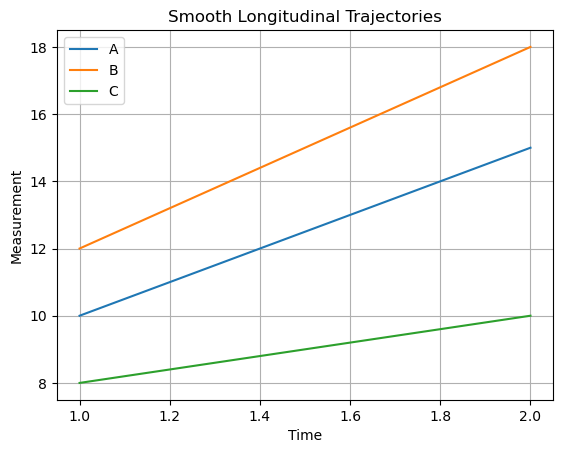

In [36]:
from scipy.interpolate import CubicSpline

# Example data (replace with your own data)
data = pd.DataFrame({
    'Subject': ['A', 'A', 'B', 'B', 'C', 'C'],
    'Time': [1, 2, 1, 2, 1, 2],
    'Measurement': [10, 15, 12, 18, 8, 10]
})

# Plot smooth trajectories for individual subjects
for subject, group_data in data.groupby('Subject'):
    # Perform cubic spline interpolation
    spline_func = CubicSpline(group_data['Time'], group_data['Measurement'])
    
    # Generate a denser time grid for smooth plotting
    dense_time = np.linspace(group_data['Time'].min(), group_data['Time'].max(), 100)
    
    # Plot the smooth trajectory
    plt.plot(dense_time, spline_func(dense_time), label=subject)

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.title('Smooth Longitudinal Trajectories')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_joint_plot(data, y, x_axis_title, title):
    # Create a joint plot
    joint = sns.jointplot(
        x='age_interval',
        y=y,
        data=data,
        hue='group',
        # kind='kde',
        palette={"intra": "#EC7016", "inter": "#35646E"},
        # height=8
        # common_norm=False
    )
    # Set new labels for x and y axes
    # joint.set_axis_labels('Age Interval', joint.set_axis_labels('Age Interval', 'Average Absolute Log Jacobian Value'))
    joint.set_axis_labels('Age Interval', x_axis_title, fontweight='bold')
    joint.ax_joint.grid(True)
    joint.ax_joint.set_axisbelow(True)

    # Add minor ticks to both x and y axes
    joint.ax_joint.minorticks_on()

    # joint.ax_joint.set_xlabel(fontweight='bold')
    # joint.ax_joint.set_ylabel(fontweight='bold')

    # Set the legend name to 'Pair Type'
    joint.ax_joint.legend(title='Pair Type')
    # plt.suptitle(title)

    return joint





In [187]:
create_joint_plot(df_279_no_overlap, 'avg_log_jacobian', 'Average Log Jacobian Value')

TypeError: create_joint_plot() missing 1 required positional argument: 'title'

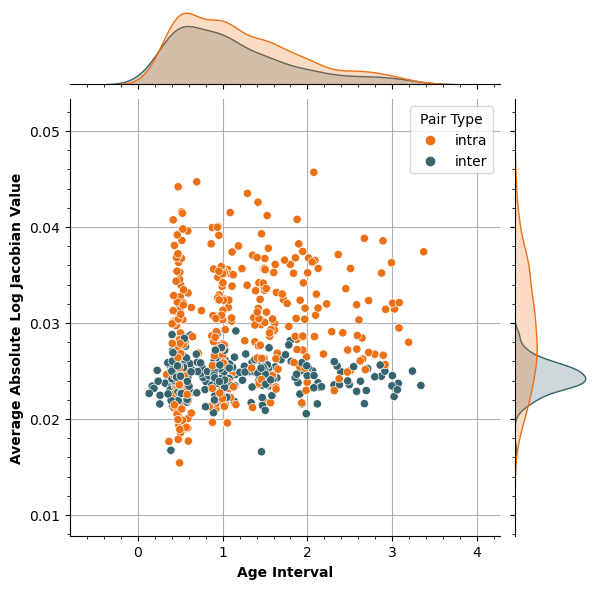

In [4]:

n_o = create_joint_plot(logJac_ia_r_NO, 'avg_abs_log_jacobian', 'Average Absolute Log Jacobian Value', 'No Overlap')

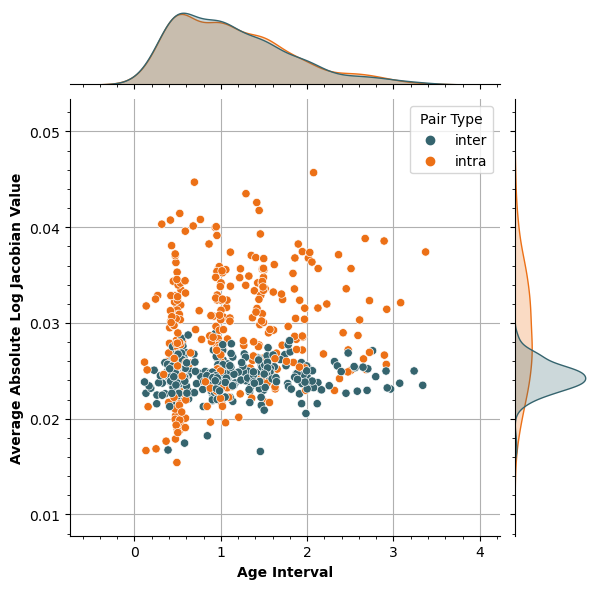

In [6]:
o = create_joint_plot(logJac_ia_r_O, 'avg_abs_log_jacobian', 'Average Absolute Log Jacobian Value', 'Overlap')

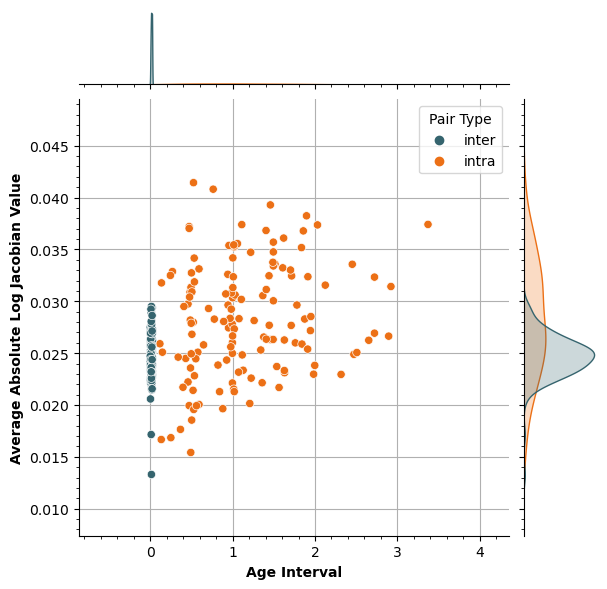

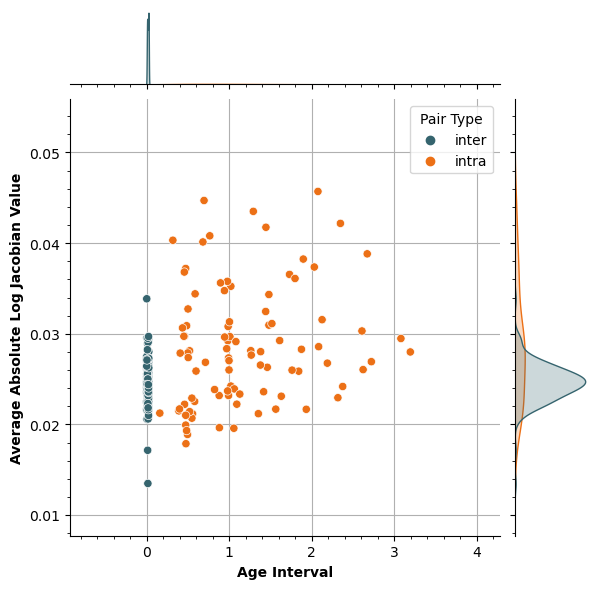

In [191]:

# Assuming you have a figure with two subplots arranged in one row and two columns
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot
# plt.sca(axs[0])  # Set the current axis to the first subplot
o = create_joint_plot(df_279_overlap, 'avg_abs_log_jacobian', 'Average Absolute Log Jacobian Value', 'Overlap')
# plt.title('Overlap')

# Second subplot
# plt.sca(axs[1])  # Set the current axis to the second subplot
n_o = create_joint_plot(df_279_no_overlap, 'avg_abs_log_jacobian', 'Average Absolute Log Jacobian Value', 'No Overlap')
# plt.title('No Overlap')

# plt.tight_layout()  # Adjust layout
# plt.show()

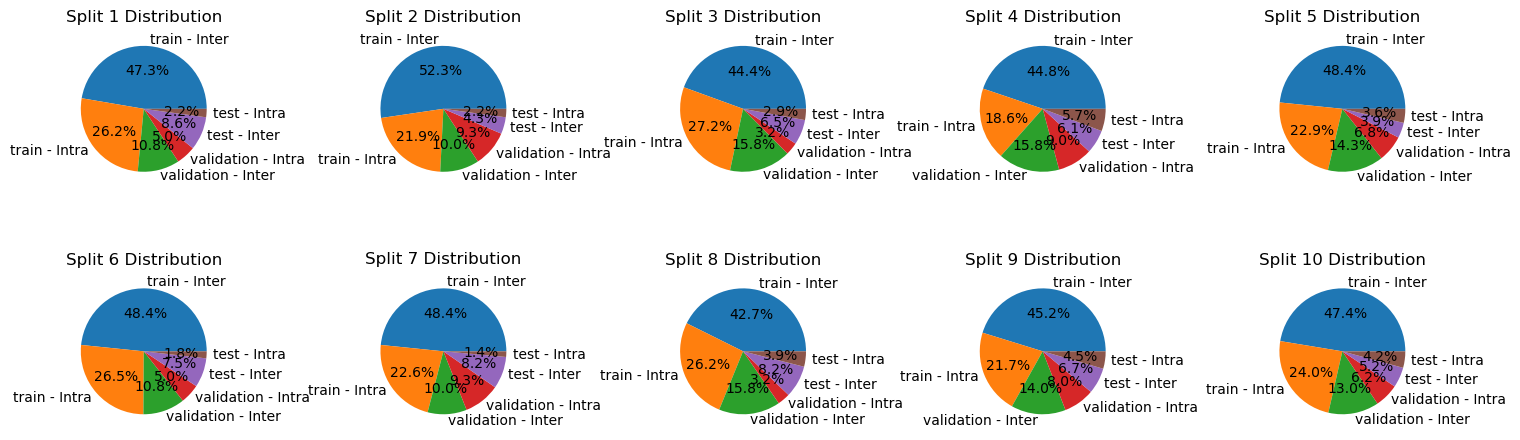

In [63]:
import matplotlib.pyplot as plt

# Example counts for 'intra' and 'inter' for each split
splits_counts_no_overlap = [
    {'train': {'inter': 132, 'intra': 73}, 'validation': {'inter': 30, 'intra': 14}, 'test': {'inter': 24, 'intra': 6}},
    {'train': {'inter': 146, 'intra': 61}, 'validation': {'inter': 28, 'intra': 26}, 'test': {'inter': 12, 'intra': 6}},
    {'train': {'inter': 124, 'intra': 76}, 'validation': {'inter': 44, 'intra': 9}, 'test': {'inter': 18, 'intra': 8}},
    {'train': {'inter': 125, 'intra': 52}, 'validation': {'inter': 44, 'intra': 25}, 'test': {'inter': 17, 'intra': 16}},
    {'train': {'inter': 135, 'intra': 64}, 'validation': {'inter': 40, 'intra': 19}, 'test': {'inter': 11, 'intra': 10}},
    {'train': {'inter': 135, 'intra': 74}, 'validation': {'inter': 30, 'intra': 14}, 'test': {'inter': 21, 'intra': 5}},
    {'train': {'inter': 135, 'intra': 63}, 'validation': {'inter': 28, 'intra': 26}, 'test': {'inter': 23, 'intra': 4}},
    {'train': {'inter': 119, 'intra': 73}, 'validation': {'inter': 44, 'intra': 9}, 'test': {'inter': 23, 'intra': 11}},
    {'train': {'inter': 142, 'intra': 68}, 'validation': {'inter': 44, 'intra': 25}, 'test': {'inter': 21, 'intra': 14}},
    {'train': {'inter': 146, 'intra': 74}, 'validation': {'inter': 40, 'intra': 19}, 'test': {'inter': 16, 'intra': 13}}
]

# Initialize a list to store pie chart data for each split
pie_data = []

# Create pie chart data for each split
for split_count in splits_counts:
    data = []
    labels = []
    for dataset, counts in split_count.items():
        data.extend([counts['inter'], counts['intra']])
        labels.extend([f'{dataset} - Inter', f'{dataset} - Intra'])
    pie_data.append((data, labels))

fig, axs = plt.subplots(2, 5, figsize=(15, 5))

for idx, (data, labels) in enumerate(pie_data):
    ax = axs.flatten()[idx]
    ax.pie(data, labels=labels, autopct='%1.1f%%')
    ax.set_title(f'Split {idx+1} Distribution')

plt.tight_layout()
plt.show()


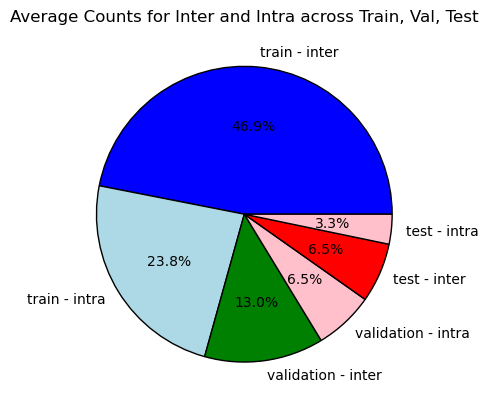

In [65]:
from collections import Counter
# Calculate total counts for each set over all 10 splits
totals = {'train': Counter(), 'validation': Counter(), 'test': Counter()}
num_splits = len(splits_counts)
for split_count in splits_counts:
    for dataset, counts in split_count.items():
        for key in counts:
            totals[dataset][key] += counts[key]

# Plotting the total counts in a pie chart
fig, ax = plt.subplots()
labels = []
sizes = []
colors = []
# Calculate average counts for each set
average_counts = {dataset: {key: count / num_splits for key, count in counts.items()} for dataset, counts in totals.items()}

for dataset, counts in average_counts.items():
    for key, value in counts.items():
        labels.append(f'{dataset} - {key}')
        sizes.append(value)
        if key == 'intra':
            if dataset == 'train':
                colors.append('lightblue')
            elif dataset == 'val':
                colors.append('lightgreen')
            else:
                colors.append('#FFC0CB')  # Custom color for other 'intra' segments
        else:
            if dataset == 'train':
                colors.append('blue')
            elif dataset == 'validation':
                colors.append('green')
            else:
                colors.append('red') 
              # Default color for 'inter'

# Create the pie chart
wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')

# Loop through wedges and set their edge color
for wedge in wedges:
    wedge.set_edgecolor('black')

ax.set_title('Average Counts for Inter and Intra across Train, Val, Test')
plt.show()

In [166]:
# Example counts for 'intra' and 'inter' for each split
splits_counts_no_overlap = [
    {'Train': {'inter': 132, 'intra': 73}, 'Validation': {'inter': 30, 'intra': 14}, 'Test': {'inter': 24, 'intra': 6}},
    {'Train': {'inter': 146, 'intra': 61}, 'Validation': {'inter': 28, 'intra': 26}, 'Test': {'inter': 12, 'intra': 6}},
    {'Train': {'inter': 124, 'intra': 76}, 'Validation': {'inter': 44, 'intra': 9}, 'Test': {'inter': 18, 'intra': 8}},
    {'Train': {'inter': 125, 'intra': 52}, 'Validation': {'inter': 44, 'intra': 25}, 'Test': {'inter': 17, 'intra': 16}},
    {'Train': {'inter': 135, 'intra': 64}, 'Validation': {'inter': 40, 'intra': 19}, 'Test': {'inter': 11, 'intra': 10}},
    {'Train': {'inter': 135, 'intra': 74}, 'Validation': {'inter': 30, 'intra': 14}, 'Test': {'inter': 21, 'intra': 5}},
    {'Train': {'inter': 135, 'intra': 63}, 'Validation': {'inter': 28, 'intra': 26}, 'Test': {'inter': 23, 'intra': 4}},
    {'Train': {'inter': 119, 'intra': 73}, 'Validation': {'inter': 44, 'intra': 9}, 'Test': {'inter': 23, 'intra': 11}},
    {'Train': {'inter': 142, 'intra': 68}, 'Validation': {'inter': 44, 'intra': 25}, 'Test': {'inter': 21, 'intra': 14}},
    {'Train': {'inter': 146, 'intra': 74}, 'Validation': {'inter': 40, 'intra': 19}, 'Test': {'inter': 16, 'intra': 13}}
]

splits_counts_overlap = [
    {'Train': {'inter': 88, 'intra': 87}, 'Validation': {'inter': 40, 'intra': 36}, 'Test': {'inter': 17, 'intra': 11}},
    {'Train': {'inter': 92, 'intra': 83}, 'Validation': {'inter': 42, 'intra': 34}, 'Test': {'inter': 14, 'intra': 14}},
    {'Train': {'inter': 124, 'intra': 76}, 'Validation': {'inter': 41, 'intra': 35}, 'Test': {'inter': 14, 'intra': 14}},
    {'Train': {'inter': 125, 'intra': 52}, 'Validation': {'inter': 44, 'intra': 32}, 'Test': {'inter': 16, 'intra': 12}},
    {'Train': {'inter': 135, 'intra': 64}, 'Validation': {'inter': 42, 'intra': 34}, 'Test': {'inter': 16, 'intra': 12}},
    {'Train': {'inter': 135, 'intra': 74}, 'Validation': {'inter': 38, 'intra': 38}, 'Test': {'inter': 17, 'intra': 11}},
    {'Train': {'inter': 135, 'intra': 63}, 'Validation': {'inter': 39, 'intra': 37}, 'Test': {'inter': 17, 'intra': 11}},
    {'Train': {'inter': 119, 'intra': 73}, 'Validation': {'inter': 39, 'intra': 37}, 'Test': {'inter': 15, 'intra': 13}},
    {'Train': {'inter': 142, 'intra': 68}, 'Validation': {'inter': 38, 'intra': 38}, 'Test': {'inter': 16, 'intra': 12}},
    {'Train': {'inter': 146, 'intra': 74}, 'Validation': {'inter': 40, 'intra': 36}, 'Test': {'inter': 14, 'intra': 13}}
]

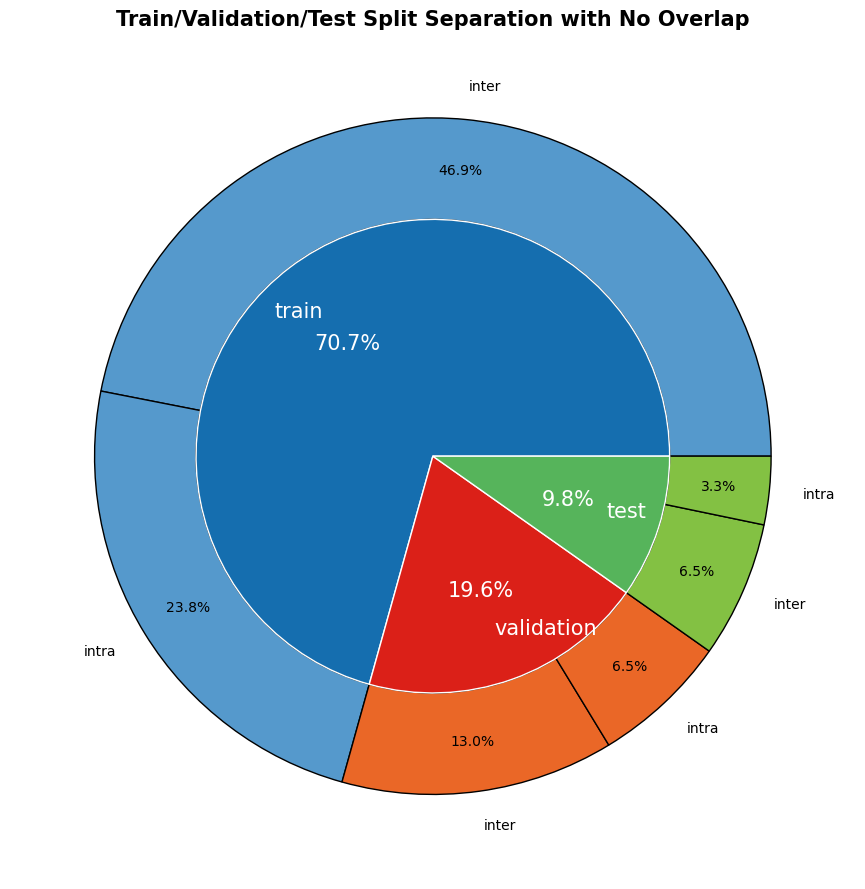

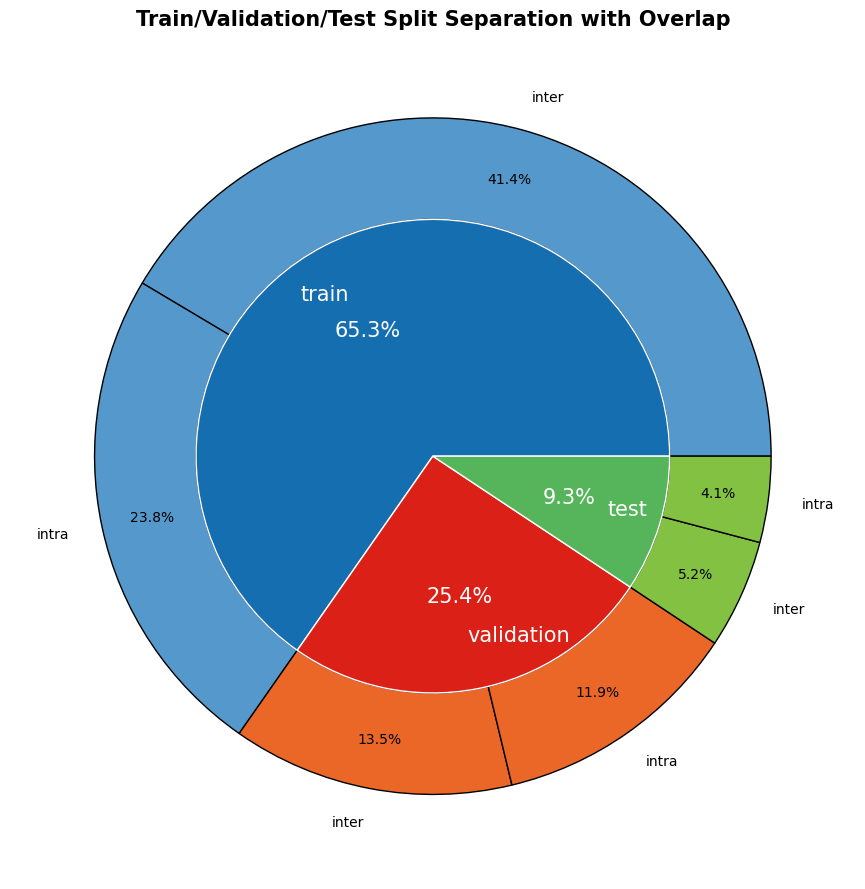

In [99]:
for splits_counts in [splits_counts_no_overlap, splits_counts_overlap]:
    # Calculate the average total counts for train, val, and test
    total_counts = {'train': 0, 'validation': 0, 'test': 0}
    for data in splits_counts:
        for key in data:
            total_counts[key] += data[key]['inter'] + data[key]['intra']
    for key in total_counts:
        total_counts[key] /= len(splits_counts)

    # Calculate the average inter and intra values per each set (train, val, test)
    avg_inter = {'train': 0, 'validation': 0, 'test': 0}
    avg_intra = {'train': 0, 'validation': 0, 'test': 0}

    for data in splits_counts:
        for category in avg_inter:
            avg_inter[category] += data[category]['inter']
            avg_intra[category] += data[category]['intra']

    for category in avg_inter:
        avg_inter[category] /= len(splits_counts)
        avg_intra[category] /= len(splits_counts)

    # Create lists of the calculated averages
    inter_values = [avg_inter[key] for key in avg_inter]
    intra_values = [avg_intra[key] for key in avg_intra]

    interleaved = [val for pair in zip(inter_values, intra_values) for val in pair]
    labels_outer = 3*['inter','intra']

    fig, ax = plt.subplots(figsize=(12, 9))

    inner_colors = ['#156EAF', '#DB2018', '#56B45B']
    outer_colors_single = ['#5599CC', '#EA6727', '#83C143']
    outer_colors = np.repeat(outer_colors_single, 2)
    size = 0.3
    r = 1

    # Generating pie charts
    ax.pie(interleaved, labels=labels_outer, radius=r,
        colors=outer_colors, wedgeprops=dict(width=size, edgecolor='k'), autopct='%1.1f%%', pctdistance=0.85)
    ax.pie([total_counts['train'], total_counts['validation'], total_counts['test']],labels=total_counts.keys() , radius=r - size, colors=inner_colors,
        labeldistance=0.77, textprops=dict(color='w', fontsize=15), wedgeprops=dict(edgecolor='w'), autopct='%1.1f%%')#, pctdistance=0.85)
    
    # Set the title for each pie chart
    # Set the title for each pie chart
    title_text = 'Train/Validation/Test Split Separation with No Overlap' if splits_counts == splits_counts_no_overlap else 'Train/Validation/Test Split Separation with Overlap'
    ax.set_title(title_text, fontsize=15, fontdict={'weight': 'bold'})

    plt.tight_layout()
    plt.show()

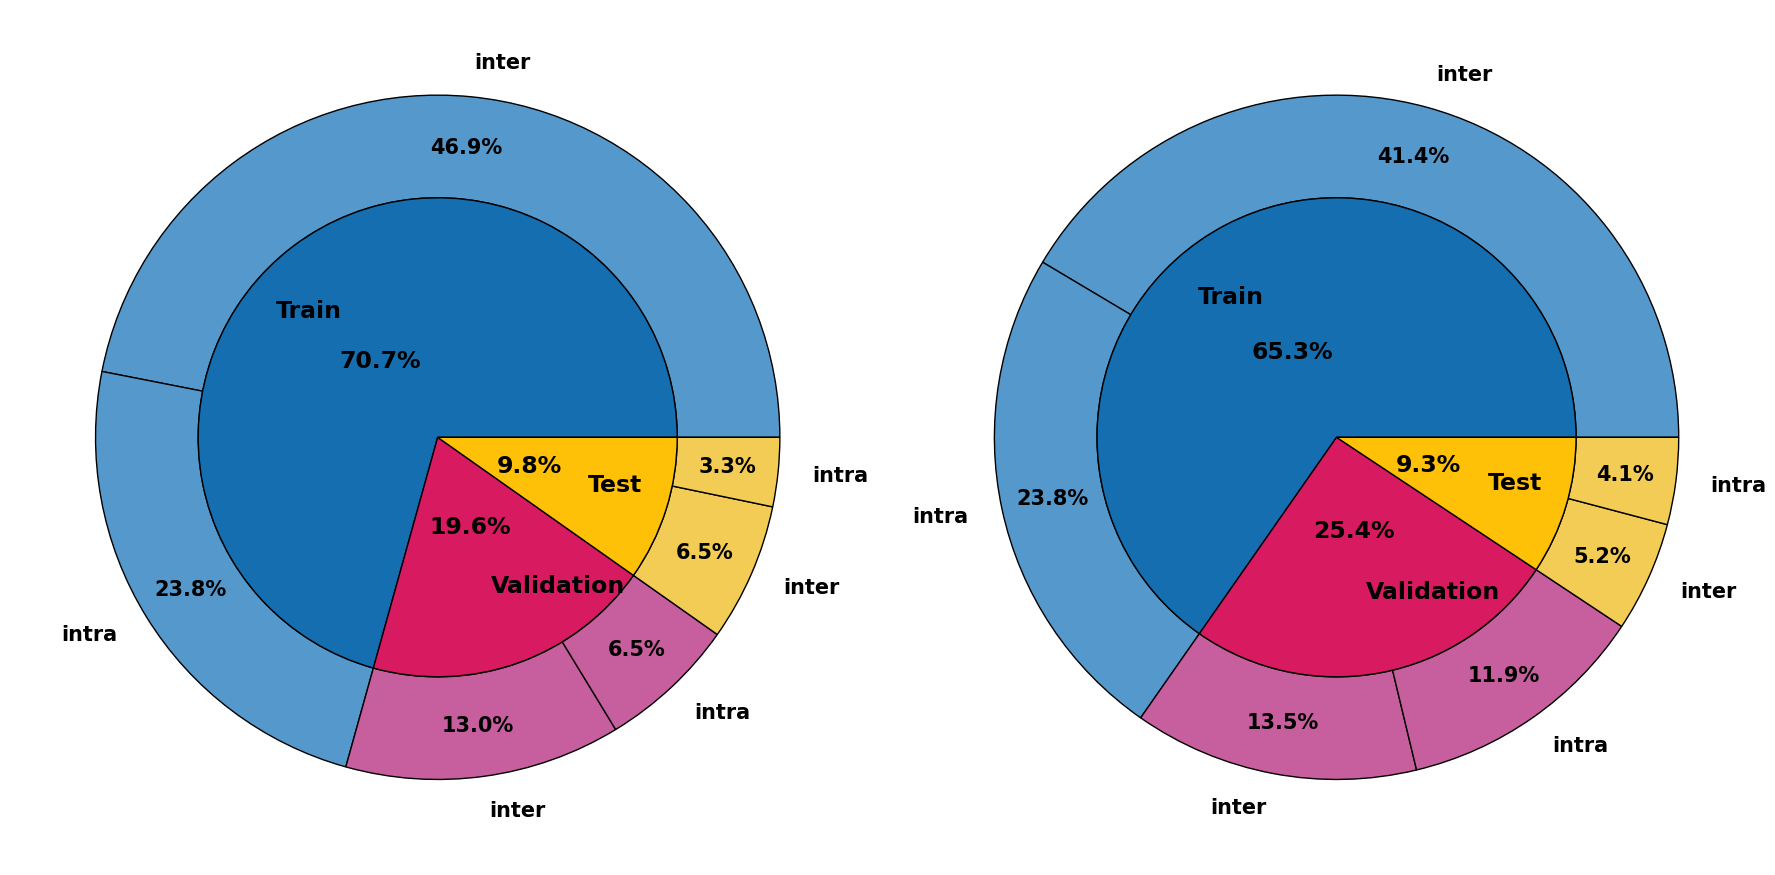

In [172]:
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

for index, splits_counts in enumerate([splits_counts_no_overlap, splits_counts_overlap]):
    # Calculate the average total counts for train, val, and test
    total_counts = {'Train': 0, 'Validation': 0, 'Test': 0}
    for data in splits_counts:
        for key in data:
            total_counts[key] += data[key]['inter'] + data[key]['intra']
    for key in total_counts:
        total_counts[key] /= len(splits_counts)

    # Calculate the average inter and intra values per each set (train, val, test)
    avg_inter = {'Train': 0, 'Validation': 0, 'Test': 0}
    avg_intra = {'Train': 0, 'Validation': 0, 'Test': 0}

    for data in splits_counts:
        for category in avg_inter:
            avg_inter[category] += data[category]['inter']
            avg_intra[category] += data[category]['intra']

    for category in avg_inter:
        avg_inter[category] /= len(splits_counts)
        avg_intra[category] /= len(splits_counts)

    # Create lists of the calculated averages
    inter_values = [avg_inter[key] for key in avg_inter]
    intra_values = [avg_intra[key] for key in avg_intra]

    interleaved = [val for pair in zip(inter_values, intra_values) for val in pair]
    labels_outer = 3*['inter','intra']

    inner_colors = ['#156EAF', '#D81B60', '#FFC107']
    outer_colors_single = ['#5599CC', '#C75E9E', '#F3CC56']
    outer_colors = np.repeat(outer_colors_single, 2)
    size = 0.3
    r = 1

    # Generating pie charts
    ax = axs[index]
    ax.pie(interleaved, labels=labels_outer, radius=r,
           colors=outer_colors, wedgeprops=dict(width=size, edgecolor='k'), autopct='%1.1f%%', textprops=dict(color='k', fontsize=15, fontweight='bold'), pctdistance=0.85)
    ax.pie([total_counts['Train'], total_counts['Validation'], total_counts['Test']], labels=total_counts.keys(), radius=r - size, colors=inner_colors,
           labeldistance=0.659, textprops=dict(color='k', fontsize=17, fontweight='bold'), wedgeprops=dict(edgecolor='k'), autopct='%1.1f%%', pctdistance=0.4)

    # Set the title for each pie chart
    # title_text = 'Train/Validation/Test Split Separation with No Overlap' if splits_counts == splits_counts_no_overlap else 'Train/Validation/Test Split Separation with Overlap'
    # ax.set_title(title_text, fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()


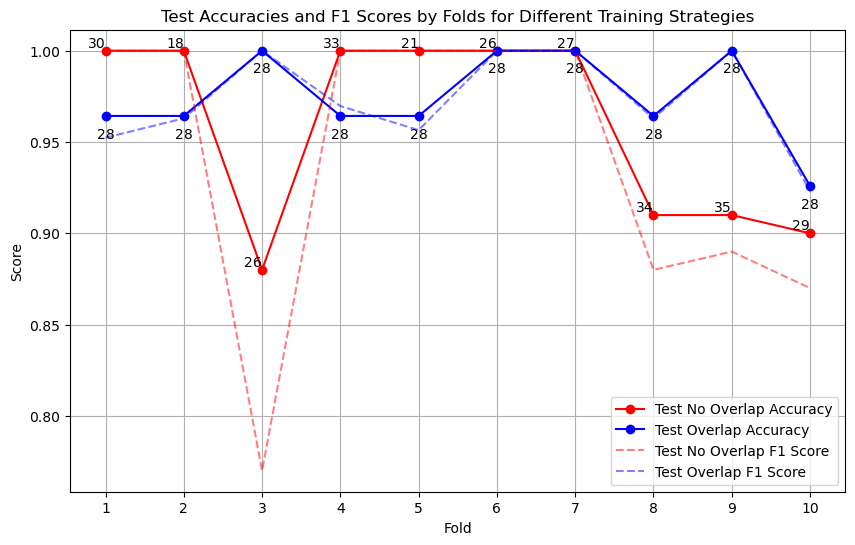

In [82]:
test_no_overlap_acc = [ 1.0, 1.0, 0.88, 1.0, 1.0, 1.0, 1.0, 0.91, 0.91, 0.90]
test_no_overlap_f1 = [ 1, 1, 0.77, 1, 1, 1, 1, 0.88, 0.89, 0.87]
test_qty_no_overlap = [ 30, 18, 26, 33, 21, 26, 27, 34, 35, 29]

test_overlap_acc = [0.9642857142857143, 0.9642857142857143, 1.0, 0.9642857142857143, 0.9642857142857143, 1.0, 1.0, 0.9642857142857143, 1.0, 0.9259259259259259]
test_overlap_f1 = [0.9523809523809523, 0.962962962962963, 1.0, 0.9696969696969697, 0.9565217391304348, 1.0, 1.0, 0.962962962962963, 1.0, 0.9230769230769231]
test_qty_overlap = 10*[28]

plt.figure(figsize=(10, 6))

plt.plot(test_no_overlap_acc, 'ro-', label='Test No Overlap Accuracy')
plt.plot(test_overlap_acc, 'bo-', label='Test Overlap Accuracy')

plt.plot(test_no_overlap_f1, 'r--', label='Test No Overlap F1 Score', alpha=0.5)
plt.plot(test_overlap_f1, 'b--', label='Test Overlap F1 Score', alpha=0.5)

for x, y in zip(range(10), test_no_overlap_acc):
    plt.text(x, y+0.002, str(test_qty_no_overlap[x]), ha='right')

for x, y in zip(range(10), test_overlap_acc):
    plt.text(x, y-0.006, str(test_qty_overlap[x]), ha='center', va='top')

plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Test Accuracies and F1 Scores by Folds for Different Training Strategies')
plt.xticks(range(10), [str(i+1) for i in range(10)])
plt.legend()
plt.grid(True)
plt.show()




In [163]:
[str(i+1) for i in range(10)]

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

[0.96, 0.975, 0.941, 0.973]
0.04959838707054897 0.02341269841269841 0.07841555968046138 0.02513326730429045


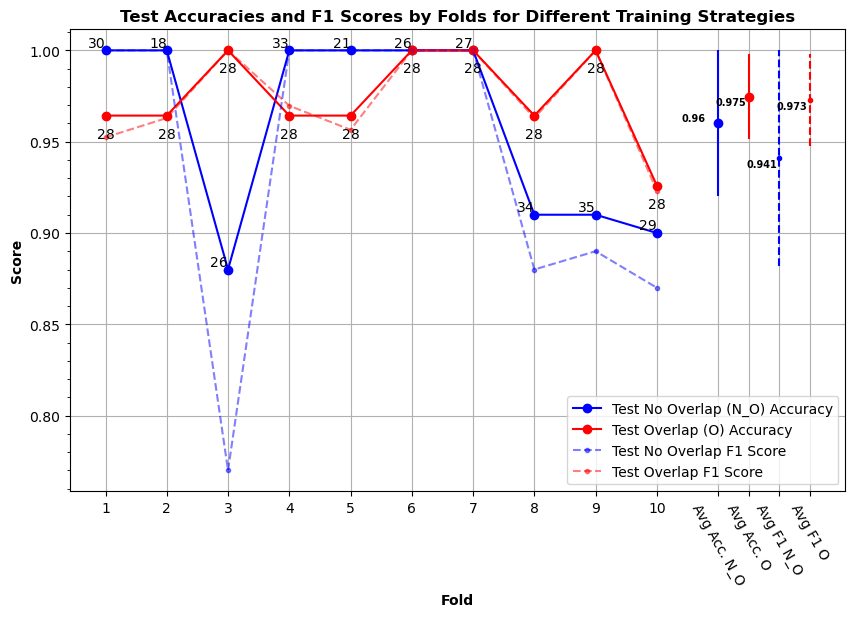

In [179]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
test_no_overlap_acc = [1.0, 1.0, 0.88, 1.0, 1.0, 1.0, 1.0, 0.91, 0.91, 0.90]
test_no_overlap_f1 = [1, 1, 0.77, 1, 1, 1, 1, 0.88, 0.89, 0.87]
test_qty_no_overlap = [30, 18, 26, 33, 21, 26, 27, 34, 35, 29]

test_overlap_acc = [0.9642857142857143, 0.9642857142857143, 1.0, 0.9642857142857143, 0.9642857142857143, 1.0, 1.0, 0.9642857142857143, 1.0, 0.9259259259259259]
test_overlap_f1 = [0.9523809523809523, 0.962962962962963, 1.0, 0.9696969696969697, 0.9565217391304348, 1.0, 1.0, 0.962962962962963, 1.0, 0.9230769230769231]
test_qty_overlap = 10 * [28]

# plt.figure(figsize=(10, 6))

plt.plot(test_no_overlap_acc, 'bo-', label='Test No Overlap (N_O) Accuracy')
plt.plot(test_overlap_acc, 'ro-', label='Test Overlap (O) Accuracy')

plt.plot(test_no_overlap_f1, 'b.--', label='Test No Overlap F1 Score', alpha=0.5)
plt.plot(test_overlap_f1, 'r.--', label='Test Overlap F1 Score', alpha=0.5)

# Test No Overlap
avg_no_overlap_acc = np.mean(test_no_overlap_acc)
std_no_overlap_acc = np.std(test_no_overlap_acc)
yerr_no_acc = std_no_overlap_acc if avg_no_overlap_acc + std_no_overlap_acc <= 1 else 1 - avg_no_overlap_acc
eb1 = plt.errorbar(10, avg_no_overlap_acc, yerr=yerr_no_acc, fmt='bo')


avg_no_overlap_f1 = np.mean(test_no_overlap_f1)
std_no_overlap_f1 = np.std(test_no_overlap_f1)
yerr_no_f1 = std_no_overlap_f1 if avg_no_overlap_f1 + std_no_overlap_f1 <= 1 else 1 - avg_no_overlap_f1
eb2 = plt.errorbar(11, avg_no_overlap_f1, yerr=yerr_no_f1, fmt='b.')
eb2[-1][0].set_linestyle('--')

# Test Overlap
avg_overlap_acc = np.mean(test_overlap_acc)
std_overlap_acc = np.std(test_overlap_acc)
plt.errorbar(10.5, avg_overlap_acc, yerr=std_overlap_acc, fmt='ro')

avg_overlap_f1 = np.mean(test_overlap_f1)
std_overlap_f1 = np.std(test_overlap_f1)
# Ensure the error bars don't exceed y=1
yerr_o_f1 = std_overlap_f1 if avg_overlap_f1 + std_overlap_f1 <= 1 else 1 - avg_overlap_f1
eb4 = plt.errorbar(11.5, avg_overlap_f1, yerr=yerr_o_f1, fmt='r.')
eb4[-1][0].set_linestyle('--')

for x, y in zip(range(10), test_no_overlap_acc):
    plt.text(x, y + 0.002, str(test_qty_no_overlap[x]), ha='right')

for x, y in zip(range(10), test_overlap_acc):
    plt.text(x, y - 0.006, str(test_qty_overlap[x]), ha='center', va='top')

# Determine the y-axis ticks
# y_ticks = plt.gca().get_yticks()
ro = 3
y_avg_values = [np.round(np.mean(test_no_overlap_acc),ro), np.round(np.mean(test_overlap_acc),ro), np.round(np.mean(test_no_overlap_f1),ro), np.round(np.mean(test_overlap_f1),ro)]
print(y_avg_values)
print(std_no_overlap_acc, std_overlap_acc, std_no_overlap_f1, std_overlap_f1)

plt.text(10- 0.4, y_avg_values[0], str(y_avg_values[0]), ha='center', va='bottom', fontsize=7, weight='bold')
plt.text(10.5- 0.29, y_avg_values[1] - 0.006, str(y_avg_values[1]), ha='center', va='bottom', fontsize=7, weight='bold')
plt.text(11- 0.29, y_avg_values[2] - 0.006, str(y_avg_values[2]), ha='center', va='bottom', fontsize=7, weight='bold')
plt.text(11.5- 0.29, y_avg_values[3] - 0.006, str(y_avg_values[3]), ha='center', va='bottom', fontsize=7, weight='bold')
# y_tick_labels = [f'{val:.2f}' for val in y_ticks] + [f'{val:.2f}' for val in y_avg_values]
# # Set specific y-axis ticks and labels
# plt.yticks(np.concatenate([y_ticks, y_avg_values]), y_tick_labels)

plt.xlabel('Fold', weight='bold')
plt.ylabel('Score', weight='bold')
plt.title('Test Accuracies and F1 Scores by Folds for Different Training Strategies', weight='bold')
plt.xticks([0, 1,2,3,4,5,6,7,8,9,10,10.5,11,11.5], [str(i+1) for i in range(10)] + ['Avg Acc. N_O', 'Avg Acc. O', 'Avg F1 N_O', 'Avg F1 O'])
# Rotate specific labels by -60 degrees
plt.setp(plt.gca().get_xticklabels()[-4:], rotation=-60, ha="center")
plt.legend(loc='lower right')
# Currently, there are no minor ticks,
#   so trying to make them visible would have no effect
ax.yaxis.get_ticklocs(minor=True) 
# Initialize minor ticks
ax.minorticks_on()

# Now minor ticks exist and are turned on for both axes

# Turn off x-axis minor ticks
ax.xaxis.set_tick_params(which='minor', bottom=False)
plt.grid(True)
plt.show()


[0.96, 0.975, 0.941, 0.973]
0.04959838707054897 0.02341269841269841 0.07841555968046138 0.02513326730429045


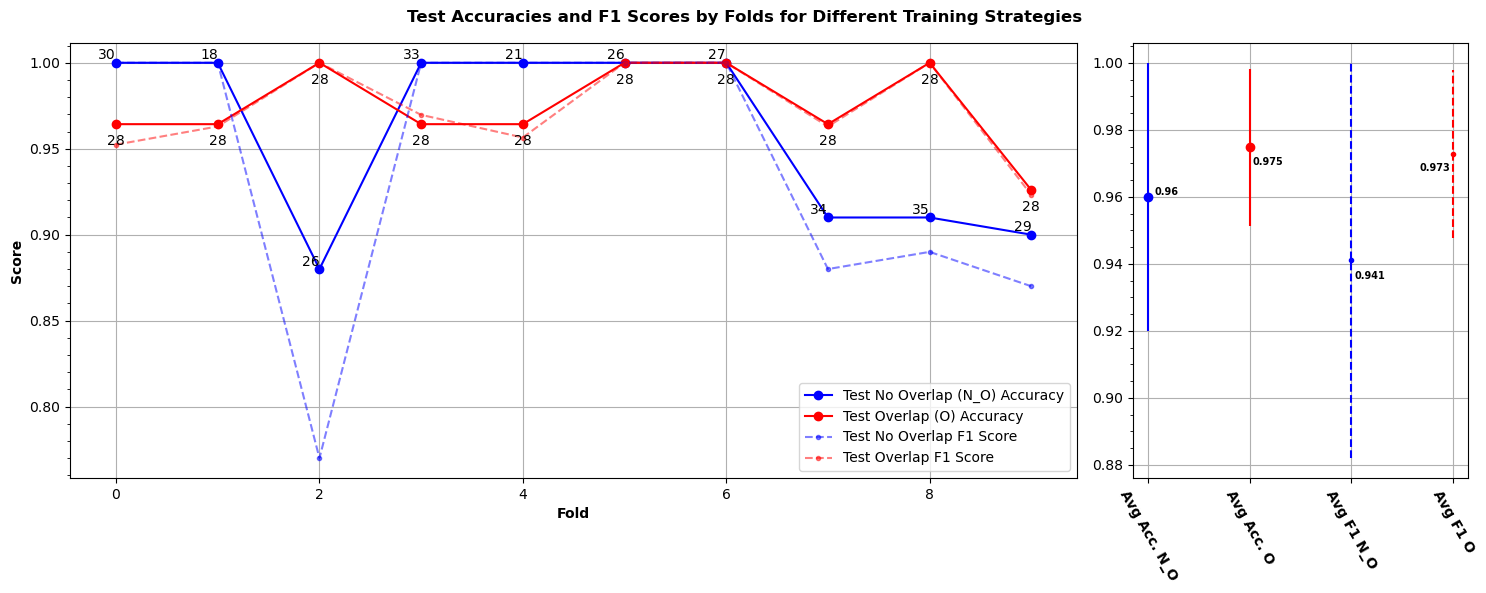

In [219]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})

test_no_overlap_acc = [1.0, 1.0, 0.88, 1.0, 1.0, 1.0, 1.0, 0.91, 0.91, 0.90]
test_no_overlap_f1 = [1, 1, 0.77, 1, 1, 1, 1, 0.88, 0.89, 0.87]
test_qty_no_overlap = [30, 18, 26, 33, 21, 26, 27, 34, 35, 29]

test_overlap_acc = [0.9642857142857143, 0.9642857142857143, 1.0, 0.9642857142857143, 0.9642857142857143, 1.0, 1.0, 0.9642857142857143, 1.0, 0.9259259259259259]
test_overlap_f1 = [0.9523809523809523, 0.962962962962963, 1.0, 0.9696969696969697, 0.9565217391304348, 1.0, 1.0, 0.962962962962963, 1.0, 0.9230769230769231]
test_qty_overlap = 10 * [28]

# plt.figure(figsize=(10, 6))

ax1.plot(test_no_overlap_acc, 'bo-', label='Test No Overlap (N_O) Accuracy')
ax1.plot(test_overlap_acc, 'ro-', label='Test Overlap (O) Accuracy')

ax1.plot(test_no_overlap_f1, 'b.--', label='Test No Overlap F1 Score', alpha=0.5)
ax1.plot(test_overlap_f1, 'r.--', label='Test Overlap F1 Score', alpha=0.5)

# Test No Overlap
avg_no_overlap_acc = np.mean(test_no_overlap_acc)
std_no_overlap_acc = np.std(test_no_overlap_acc)
yerr_no_acc = std_no_overlap_acc if avg_no_overlap_acc + std_no_overlap_acc <= 1 else 1 - avg_no_overlap_acc
eb1 = ax2.errorbar(1, avg_no_overlap_acc, yerr=yerr_no_acc, fmt='bo')


avg_no_overlap_f1 = np.mean(test_no_overlap_f1)
std_no_overlap_f1 = np.std(test_no_overlap_f1)
yerr_no_f1 = std_no_overlap_f1 if avg_no_overlap_f1 + std_no_overlap_f1 <= 1 else 1 - avg_no_overlap_f1
eb2 = ax2.errorbar(2, avg_no_overlap_f1, yerr=yerr_no_f1, fmt='b.')
eb2[-1][0].set_linestyle('--')

# Test Overlap
avg_overlap_acc = np.mean(test_overlap_acc)
std_overlap_acc = np.std(test_overlap_acc)
ax2.errorbar(1.5, avg_overlap_acc, yerr=std_overlap_acc, fmt='ro')

avg_overlap_f1 = np.mean(test_overlap_f1)
std_overlap_f1 = np.std(test_overlap_f1)
# Ensure the error bars don't exceed y=1
yerr_o_f1 = std_overlap_f1 if avg_overlap_f1 + std_overlap_f1 <= 1 else 1 - avg_overlap_f1
eb4 = ax2.errorbar(2.5, avg_overlap_f1, yerr=yerr_o_f1, fmt='r.')
eb4[-1][0].set_linestyle('--')

for x, y in zip(range(10), test_no_overlap_acc):
    ax1.text(x, y + 0.002, str(test_qty_no_overlap[x]), ha='right')

for x, y in zip(range(10), test_overlap_acc):
    ax1.text(x, y - 0.006, str(test_qty_overlap[x]), ha='center', va='top')

# Determine the y-axis ticks
# y_ticks = plt.gca().get_yticks()
ro = 3
y_avg_values = [np.round(np.mean(test_no_overlap_acc),ro), np.round(np.mean(test_overlap_acc),ro), np.round(np.mean(test_no_overlap_f1),ro), np.round(np.mean(test_overlap_f1),ro)]
print(y_avg_values)
print(std_no_overlap_acc, std_overlap_acc, std_no_overlap_f1, std_overlap_f1)

ax2.text(1+ 0.09, y_avg_values[0], str(y_avg_values[0]), ha='center', va='bottom', fontsize=7, weight='bold')
ax2.text(1.5+ 0.09, y_avg_values[1] - 0.006, str(y_avg_values[1]), ha='center', va='bottom', fontsize=7, weight='bold')
ax2.text(2+ 0.09, y_avg_values[2] - 0.006, str(y_avg_values[2]), ha='center', va='bottom', fontsize=7, weight='bold')
ax2.text(2.5- 0.09, y_avg_values[3] - 0.006, str(y_avg_values[3]), ha='center', va='bottom', fontsize=7, weight='bold')
# y_tick_labels = [f'{val:.2f}' for val in y_ticks] + [f'{val:.2f}' for val in y_avg_values]
# # Set specific y-axis ticks and labels
# plt.yticks(np.concatenate([y_ticks, y_avg_values]), y_tick_labels)

ax1.set_xlabel('Fold', weight='bold')
ax1.set_ylabel('Score', weight='bold')
plt.suptitle('Test Accuracies and F1 Scores by Folds for Different Training Strategies', weight='bold')
# plt.xticks([0, 1,2,3,4,5,6,7,8,9,10,10.5,11,11.5], [str(i+1) for i in range(10)] + ['Avg Acc. N_O', 'Avg Acc. O', 'Avg F1 N_O', 'Avg F1 O'])
# Rotate specific labels by -60 degrees
# plt.setp(plt.gca().get_xticklabels()[-4:], rotation=-60, ha="center")
ax1.legend(loc='lower right')
ax2.set_xticks([1,1.5,2,2.5], ['Avg Acc. N_O', 'Avg Acc. O', 'Avg F1 N_O', 'Avg F1 O'], rotation=-60, weight='bold')
# Currently, there are no minor ticks,
#   so trying to make them visible would have no effect
ax1.yaxis.get_ticklocs(minor=True) 
# Initialize minor ticks
ax1.minorticks_on()
ax2.minorticks_on()

# Now minor ticks exist and are turned on for both axes

# Turn off x-axis minor ticks
ax1.xaxis.set_tick_params(which='minor', bottom=False)
ax2.xaxis.set_tick_params(which='minor', bottom=False)
ax2.grid(True)
ax1.grid(True)
fig.tight_layout()
plt.show()


1.0


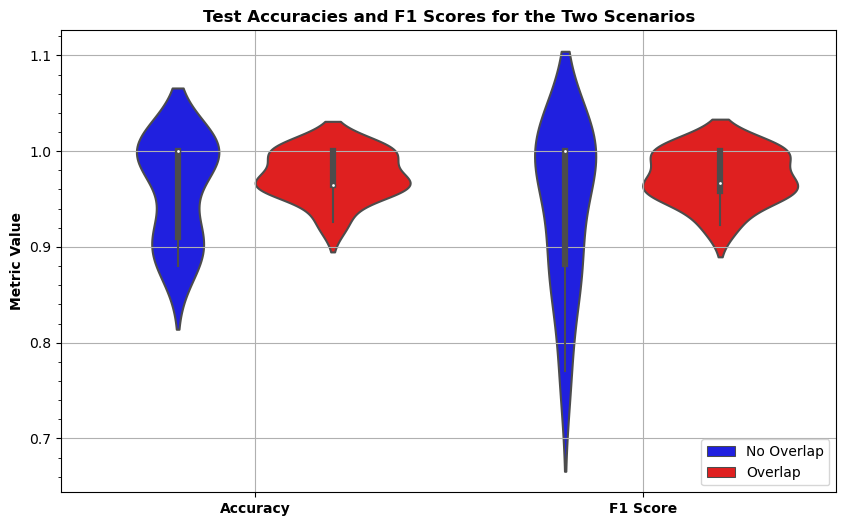

In [217]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Existing data
test_no_overlap_acc = [1.0, 1.0, 0.88, 1.0, 1.0, 1.0, 1.0, 0.91, 0.91, 0.90]
test_no_overlap_f1 = [1, 1, 0.77, 1, 1, 1, 1, 0.88, 0.89, 0.87]
test_overlap_acc = [0.9642857142857143, 0.9642857142857143, 1.0, 0.9642857142857143, 0.9642857142857143, 1.0, 1.0, 0.9642857142857143, 1.0, 0.9259259259259259]
test_overlap_f1 = [0.9523809523809523, 0.962962962962963, 1.0, 0.9696969696969697, 0.9565217391304348, 1.0, 1.0, 0.962962962962963, 1.0, 0.9230769230769231]

# Combine the data into a DataFrame
data = {
    'Test Type': ['Accuracy'] * 10 + ['F1 Score'] * 10 + ['Accuracy'] * 10 + ['F1 Score'] * 10,
    'Scores': test_no_overlap_acc + test_no_overlap_f1 + test_overlap_acc + test_overlap_f1,
    'Scenario': ['No Overlap']*20 + ['Overlap']*20
}

print(np.median(test_no_overlap_acc))
df = pd.DataFrame(data)
# print(df)

# Plot using Seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x='Test Type', y='Scores', data=df, hue='Scenario', notch=True, showcaps=False, medianprops={"color": "k", "linewidth": 2}, palette={"No Overlap": "blue", "Overlap": "red"}).set(xlabel=None) #,
            # flierprops={"marker": "x"},
            # boxprops={"facecolor": (.3, .5, .7, .5)},
            # medianprops={"color": "r", "linewidth": 2},
            # palette={"No Overlap Accuracy": "blue", "No Overlap F1 Score": "blue",
            #          "Overlap Accuracy": "red", "Overlap F1 Score": "red"})

plt.ylabel('Metric Value', weight='bold')
plt.title('Test Accuracies and F1 Scores for the Two Scenarios', weight='bold')
plt.xticks(weight='bold')
#   so trying to make them visible would have no effect
ax.yaxis.get_ticklocs(minor=True) 
# Initialize minor ticks
ax.minorticks_on()

# Now minor ticks exist and are turned on for both axes

# Turn off x-axis minor ticks
ax.xaxis.set_tick_params(which='minor', bottom=False)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


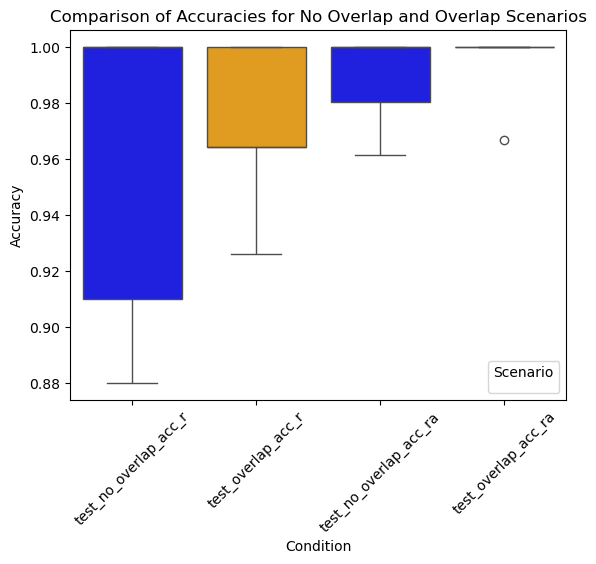

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Existing data
test_no_overlap_acc_r = [1.0, 1.0, 0.88, 1.0, 1.0, 1.0, 1.0, 0.91, 0.91, 0.90]
test_no_overlap_f1_r = [1, 1, 0.77, 1, 1, 1, 1, 0.88, 0.89, 0.87]
test_overlap_acc_r = [0.9642857142857143, 0.9642857142857143, 1.0, 0.9642857142857143, 0.9642857142857143, 1.0, 1.0, 0.9642857142857143, 1.0, 0.9259259259259259]
test_overlap_f1_r = [0.9523809523809523, 0.962962962962963, 1.0, 0.9696969696969697, 0.9565217391304348, 1.0, 1.0, 0.962962962962963, 1.0, 0.9230769230769231]

test_no_overlap_acc_ra = [1.0, 1.0, 0.9736842105263158, 0.9615384615384616, 1.0, 1.0, 1.0, 0.9642857142857143, 1.0, 1.0]
test_no_overlap_f1_ra = [1.0, 1.0, 0.9600000000000001, 0.888888888888889, 1.0, 1.0, 1.0, 0.967741935483871, 1.0, 1.0]
test_overlap_f1_ra = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9696969696969697, 1.0, 1.0]
test_overlap_acc_ra = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9666666666666667, 1.0, 1.0]

# Combine the data into a single list
accuracies = test_no_overlap_acc_r + test_overlap_acc_r + test_no_overlap_acc_ra + test_overlap_acc_ra

# Create a corresponding list to specify the conditions
conditions = ['test_no_overlap_acc_r'] * len(test_no_overlap_acc_r) + ['test_overlap_acc_r'] * len(test_overlap_acc_r) + ['test_no_overlap_acc_ra'] * len(test_no_overlap_acc_ra) + ['test_overlap_acc_ra'] * len(test_overlap_acc_ra)

# Create a DataFrame from the data
data = {'Accuracy': accuracies, 'Condition': conditions}
df = pd.DataFrame(data)

# Plot
sns.boxplot(data=df, x='Condition', y='Accuracy', hue='Condition', palette={'test_no_overlap_acc_r': 'blue', 'test_overlap_acc_r': 'orange', 'test_no_overlap_acc_ra': 'blue', 'test_overlap_acc_ra': 'orange'})
plt.xticks(rotation=45)
plt.title('Comparison of Accuracies for No Overlap and Overlap Scenarios')
plt.xlabel('Condition')
plt.ylabel('Accuracy')
plt.legend(title='Scenario')
plt.show()



In [4]:
# Create DataFrames for each accuracy list
df_no_overlap_r = pd.DataFrame({'Accuracy': test_no_overlap_acc_r, 'Training Type': 'no overlap', 'Initialization': 'r'})
df_overlap_r = pd.DataFrame({'Accuracy': test_overlap_acc_r, 'Training Type': 'overlap', 'Initialization': 'r'})
df_no_overlap_ra = pd.DataFrame({'Accuracy': test_no_overlap_acc_ra, 'Training Type': 'no overlap', 'Initialization': 'ra'})
df_overlap_ra = pd.DataFrame({'Accuracy': test_overlap_acc_ra, 'Training Type': 'overlap', 'Initialization': 'ra'})

# Concatenate the DataFrames
df_combined = pd.concat([df_no_overlap_r, df_overlap_r, df_no_overlap_ra, df_overlap_ra], ignore_index=True)

# # Print the combined DataFrame
# print(df_combined)

# Create DataFrames for each F1 score list
df_no_overlap_f1_r = pd.DataFrame({'F1 Score': test_no_overlap_f1_r, 'Training Type': 'no overlap', 'Initialization': 'r'})
df_overlap_f1_r = pd.DataFrame({'F1 Score': test_overlap_f1_r, 'Training Type': 'overlap', 'Initialization': 'r'})
df_no_overlap_f1_ra = pd.DataFrame({'F1 Score': test_no_overlap_f1_ra, 'Training Type': 'no overlap', 'Initialization': 'ra'})
df_overlap_f1_ra = pd.DataFrame({'F1 Score': test_overlap_f1_ra, 'Training Type': 'overlap', 'Initialization': 'ra'})

# Concatenate the DataFrames
df_combined_f1 = pd.concat([df_no_overlap_f1_r, df_overlap_f1_r, df_no_overlap_f1_ra, df_overlap_f1_ra], ignore_index=True)

# # Print the combined DataFrame for F1 scores
# print(df_combined_f1)

# Combine the DataFrames along the columns axis
df_combined_full = pd.concat([df_combined, df_combined_f1['F1 Score']], axis=1)

# Print the combined DataFrame
print(df_combined_full)

    Accuracy Training Type Initialization  F1 Score
0   1.000000    no overlap              r  1.000000
1   1.000000    no overlap              r  1.000000
2   0.880000    no overlap              r  0.770000
3   1.000000    no overlap              r  1.000000
4   1.000000    no overlap              r  1.000000
5   1.000000    no overlap              r  1.000000
6   1.000000    no overlap              r  1.000000
7   0.910000    no overlap              r  0.880000
8   0.910000    no overlap              r  0.890000
9   0.900000    no overlap              r  0.870000
10  0.964286       overlap              r  0.952381
11  0.964286       overlap              r  0.962963
12  1.000000       overlap              r  1.000000
13  0.964286       overlap              r  0.969697
14  0.964286       overlap              r  0.956522
15  1.000000       overlap              r  1.000000
16  1.000000       overlap              r  1.000000
17  0.964286       overlap              r  0.962963
18  1.000000

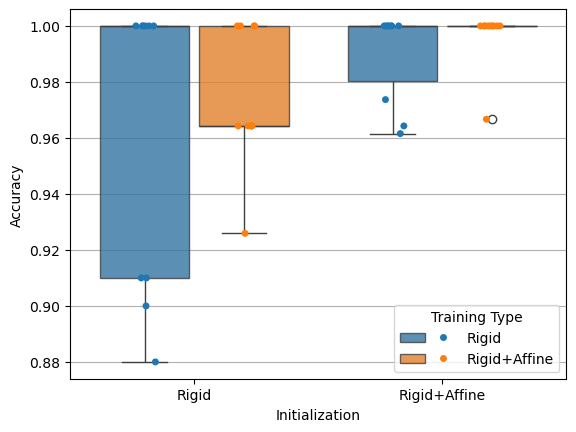

In [20]:
ax = sns.boxplot(data=df_combined_full, x="Initialization", y="Accuracy", hue="Training Type", gap=.1, boxprops={'alpha': 0.8})
sns.stripplot(data=df_combined_full, x="Initialization", y="Accuracy",
              hue="Training Type", dodge=True, ax=ax)
# Renaming the x-axis labels
plt.xticks(ticks=[0, 1], labels=["Rigid", "Rigid+Affine"])
# Add horizontal grid lines
plt.grid(axis='y')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
          labels=["Rigid", "Rigid+Affine"],
          loc='lower right', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)}, title = 'Training Type')

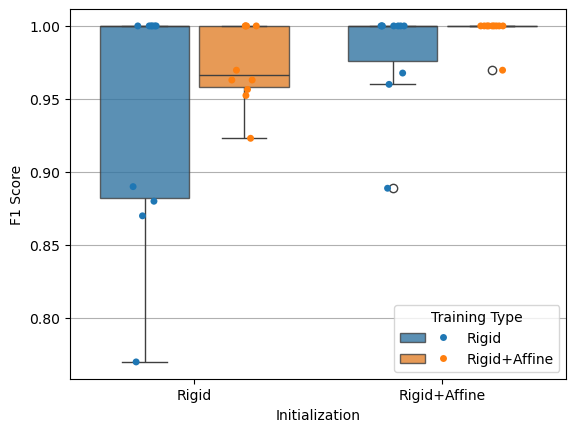

In [18]:
from matplotlib.legend_handler import HandlerTuple
ax = sns.boxplot(data=df_combined_full, x="Initialization", y="F1 Score", hue="Training Type", gap=.1, boxprops={'alpha': 0.8})
sns.stripplot(data=df_combined_full, x="Initialization", y="F1 Score",
              hue="Training Type", dodge=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
# Renaming the x-axis labels
plt.xticks(ticks=[0, 1], labels=["Rigid", "Rigid+Affine"])
# Add horizontal grid lines
plt.grid(axis='y')
ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
          labels=["Rigid", "Rigid+Affine"],
          loc='lower right', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)}, title = 'Training Type')